In [1]:
% load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from collections import *
from nltk import *
from nltk.corpus import stopwords
from nltk.tokenize import *
from typing import *

In [8]:
mpl.rcParams["figure.figsize"] = (12, 7)

In [9]:
data_loc = "../data/id-syntax-sentence-classification.xlsx"
data_sheets = [
    "{}-{}".format(start, start + 499)
    for start in range(1, 10001, 500)
]
category_sheet = "KODE POLA"

In [10]:
category_data = pd.read_excel(data_loc, sheet_name=category_sheet, header=1)

In [11]:
category_data.head()

,kode pola,nama pola,Unnamed: 2
0,1.0,kalimat tunggal,simple sentence
1,2.0,kalimat majemuk setara,compound sentence
2,3.0,kalimat majemuk bertingkat,complex sentence
3,4.0,kalimat majemuk kompleks,compound-complex sentence
4,5.0,kalimat taklengkap,incomplete sentence


In [12]:
data: List[pd.DataFrame] = [
    pd.read_excel(data_loc, sheet_name=data_sheet)
    for data_sheet in data_sheets
]

In [13]:
all_data: pd.DataFrame = pd.concat(data)

In [14]:
itoc: Dict[str, str] = {str(row["kode pola"]): row[2] for _, row in category_data.iterrows()}

In [15]:
columns = all_data.columns
all_data = all_data.rename(columns={
    col: itoc[str(col)]
    for col in columns
    if str(col) in itoc
})

In [16]:
new_columns = all_data.columns
category_columns = [col for col in new_columns if col != "Kalimat"]

median count=827.0


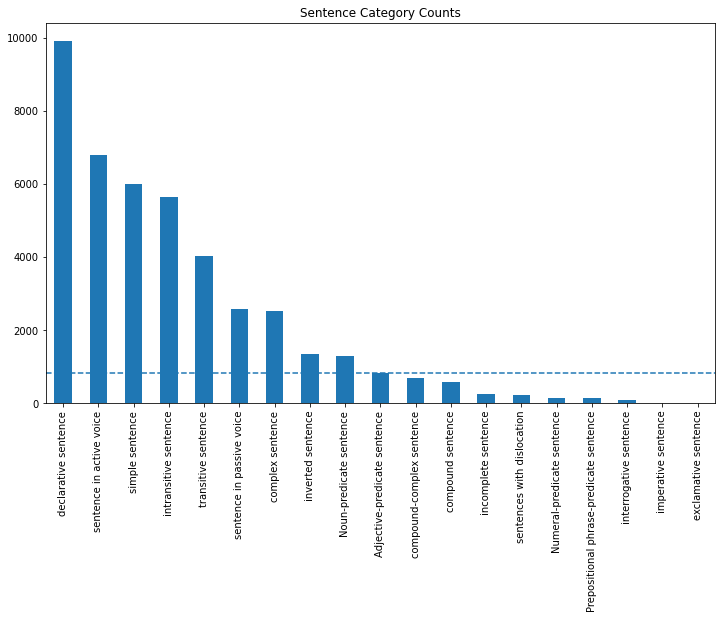

In [17]:
f, ax = plt.subplots()
all_data_counts = all_data[category_columns].sum()

plt.title("Sentence Category Counts")
(
    all_data_counts
        .sort_values(ascending=False)
        .plot
        .bar(ax=ax)
)

median_count = all_data_counts.median()
plt.axhline(median_count, linestyle="--")
print(f"median count={median_count}")


<AxesSubplot:>

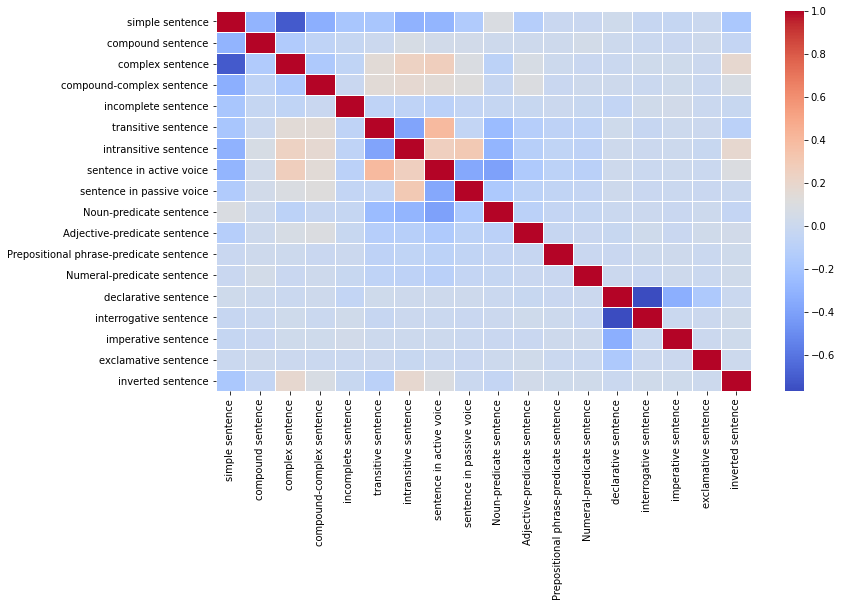

In [18]:
correlation_matrix = all_data[category_columns].corr()
sns.heatmap(
    correlation_matrix,
    linewidths=.5,
    cmap="coolwarm"
)

In [19]:


def print_all_correlated(corr_matrix, all_data, low_threshold=-.3, high_threshold=.3):
    sentence_types = corr_matrix.columns
    total_rows = all_data.shape[0]
    cols = ["type_1", "type_2", "correlation", "n_sentence", "pct"]

    negative_correlations, positive_correlations = [], []
    negative_lookup, positive_lookup = {}, {}
    for sentence_type in sentence_types:
        slice = corr_matrix[sentence_type]
        query_result = slice[(slice > high_threshold) & (slice < 1)]

        if len(query_result) > 0:
            for idx in query_result.index:
                if not ((sentence_type in positive_lookup and idx in positive_lookup[sentence_type]) or (
                        idx in positive_lookup and sentence_type in positive_lookup[idx])):

                    if sentence_type not in positive_lookup:
                        positive_lookup[sentence_type] = set()

                    positive_lookup[sentence_type].add(idx)

                    row_counts = all_data[(all_data[sentence_type]) & (all_data[idx])].shape[0]
                    positive_lookup[sentence_type] = idx
                    positive_correlations.append(
                        (sentence_type, idx, query_result[idx], row_counts, row_counts / total_rows))

    positive = pd.DataFrame(positive_correlations, columns=cols)
    print("Positive Correlation Table")
    display(positive.sort_values(by="correlation", ascending=False))

    for sentence_type in sentence_types:
        slice = corr_matrix[sentence_type]
        query_result = slice[(slice < low_threshold) & (slice > -1)]
        if len(query_result) > 0:
            for idx in query_result.index:
                if not ((sentence_type in negative_lookup and idx in negative_lookup[sentence_type]) or (
                        idx in negative_lookup and sentence_type in negative_lookup[idx])):

                    if sentence_type not in negative_lookup:
                        negative_lookup[sentence_type] = set()

                    negative_lookup[sentence_type].add(idx)
                    row_counts = all_data[(all_data[sentence_type]) & (all_data[idx])].shape[0]
                    negative_correlations.append(
                        (sentence_type, idx, query_result[idx], row_counts, row_counts / total_rows))

    print("Negative Correlation Table")
    negative = pd.DataFrame(negative_correlations, columns=cols)
    display(negative.sort_values(by="correlation", ascending=True))



In [20]:
print_all_correlated(correlation_matrix, all_data)

Positive Correlation Table


,type_1,type_2,correlation,n_sentence,pct
0,transitive sentence,sentence in active voice,0.397705,3647,0.3647
1,intransitive sentence,sentence in passive voice,0.306009,2112,0.2112


Negative Correlation Table


,type_1,type_2,correlation,n_sentence,pct
7,declarative sentence,interrogative sentence,-0.769398,15,0.0015
1,simple sentence,complex sentence,-0.708343,6,0.0006
6,sentence in active voice,Noun-predicate sentence,-0.397314,253,0.0253
4,transitive sentence,intransitive sentence,-0.383299,1344,0.1344
5,sentence in active voice,sentence in passive voice,-0.363222,1000,0.1000
8,declarative sentence,imperative sentence,-0.330804,7,0.0007
2,simple sentence,compound-complex sentence,-0.328670,4,0.0004
3,simple sentence,intransitive sentence,-0.306952,2636,0.2636
0,simple sentence,compound sentence,-0.301714,2,0.0002


## Positive Correlated Sentences
`transitive sentence` correlated positively with `sentence in active voice`, while `intransitive sentence` is correlated with `sentence in passive voice`, these are all natural.

These are probably normal in Bahasa Indonesia, since there are many transitive verbs that can be use in active voice, and intransitive verbs that can be used as passive voice.

## Negative Correlated Sentences
Some negatively correlated pairs do not make sense, most of them have number of sentences (n_sentence) less than 15. For example:
* `declarative sentence` and `imperative sentence`. It seems almost impossible to both declare and giving commands in the same sentence.
* `simple sentence` and `compound sentence`. If it is a compound sentence, which has 1 free clause and at least 1 non-free clause then it should not be `simple sentence`.



In [21]:
imperative_declarative = all_data[
    all_data["imperative sentence"] &
    all_data["declarative sentence"]
    ]

declarative_interrogative = all_data[
    all_data["interrogative sentence"] &
    all_data["declarative sentence"]
    ]

simple_complex = all_data[
    all_data["simple sentence"] &
    all_data["complex sentence"]
    ]

Sample sentence for imperative and declarative.

In [22]:
for row in imperative_declarative.head(10)["Kalimat"]:
    print(row)

Dan jangan lupa, lembaga donor macam Bank Dunia tentu tak segan mengulurkan bantuan.
Jangan dibayangkan bahwa sudah ada negosiasi yang akan diikuti dengan penyerahan harta sekian banyak yang akan diserahkan.
Namun seorang "tamu tak diundang" segera berteriak, "Jangan tembak Pak, kami hanya mengantar pesanan!"
Para pendukungnya, yang berkemeja putih dengan logo garuda merah di dada, merespons dengan pekikan "Hidup Prabowo!" berulang-ulang.
"Tulis saja kalau Anda punya datanya," katanya.
"Jangan tanya barbershop yang mana," kata Surya.
"Tapi jangan tanya siapa tiga tokoh lainnya," ucapnya, lalu tertawa.


Sample sentence for interrogative and declarative

In [23]:
for row in declarative_interrogative.head(10)["Kalimat"]:
    print(row)

”Saya bolak-balik ditanyai apa itu Jamaah Islamiyah, apakah itu semacam cabang Al-Qaidah,” ujar Shanti (bukan nama sebenarnya) melalui sambungan telepon internasional kepada TEMPO.
"Kalau orang lain dibatasi, mengapa pers tidak?" kata Barda.
"Bagaimana mau ditangkap kalau kepala desanya juga melakukan kumpul kebo?" katanya.
"Mana orang mau mengaku?" ujar Ahmad.
Saat menemukan air di sungai yang airnya sangat tenang, Sutan berdaulat berpikir “mengapa air ini tenang sekali?”.
"Mereka konstituen kami, apa salahnya?" kata sekretaris Partai Demokrat di Malaysia, Lukmanul Hakim.
Jerry bertanya, mengapa bukan anak buah Williardi yang melakukan tugas.
"Masak, Demokrat sebagai partai terbesar enggak punya calon presiden?" kata Syarief.
"Apa bisa satu orang berada di dua tempat pada waktu yang sama?" ujar Nico.
"Pak Wafid sudah bertemu dengan Pak Herman?" demikian pesan itu.


Sample sentence for simple but complex sentences

In [24]:
for row in simple_complex.head(10)["Kalimat"]:
    print(row)

Polisi kelihatan berada di "jalur yang benar" dengan menangkap sejumlah tersangka.
Diumumkan di kantor Menteri Koordinator Perekonomian di kawasan Lapangan Banteng, Jakarta Pusat, pada Jumat pekan lalu, harga baru premium Rp 6.000, solar Rp 5.500, dan minyak tanah Rp 2.500.
"Bahkan ledakan terakhir yang membunuh mereka itu pasti karena salah tarik pemicu bom," ujar perwira itu sambil terkekeh.
Itu sebabnya Nazaruddin pernah meminta anak buahnya menarik kembali separuh sogokan itu.
Letusan terjadi setelah 13 tahun kemudian tepatnya ditahun 1988 yang mengakibatkan gunung Kie Besi terbelah menjadi dua bagian.
Dari hasil perlombaan Seni Budaya KB Nusantara yang digelar mulai tanggal 1 Oktober lalu, berhasil terpilih 6 provinsi yang menjadi pemenang, yaitu masing-masing untuk Juara Umum (juara 1) diraih kontingen Provinsi Jawa Barat, Juara ke-2 Provinsi DI Yogyakarta, serta Juara 3 diraih Provinsi Bali.


it seems these are miss classified data that could be remove (the percentage is super small)

In [25]:
tokenized_sentences = all_data["Kalimat"].apply(lambda s: [s.lower() for s in word_tokenize(s)]).values

In [26]:
tokenized_sentences = np.array(tokenized_sentences)

In [75]:
def subset_from(data, sentence_category, tokenized_sentences):
    category_indexes = data[data[sentence_category].astype(bool)].index
    return tokenized_sentences[category_indexes]


def count_words(tokenized_sentences, only_words=True, n_gram=1, stopwords=set(stopwords.words("indonesian"))):
    counter = FreqDist()
    for s in tokenized_sentences:
        s = [token
             for token in s
             if ((only_words and re.match("[a-z0-9]+", token)) and
                 (token not in stopwords))]
        if n_gram > 1:
            s = list(ngrams(s, n=n_gram))
        counter.update(s)
    return counter

In [55]:
sentence_categories = [col for col in all_data.columns if col != "Kalimat"]

In [76]:
word_counts_per_categories = {
    sentence_category: count_words(subset_from(all_data, sentence_category, tokenized_sentences))
    for sentence_category in sentence_categories
}

bigram_counts_per_categories = {
    sentence_category: count_words(subset_from(all_data, sentence_category, tokenized_sentences), n_gram=2)
    for sentence_category in sentence_categories
}

In [93]:
for sentence_category in word_counts_per_categories.keys():
    common_words = word_counts_per_categories[sentence_category].most_common(10)
    common_words = ", ".join([w[0] for w in common_words])
    print(f"common words for {sentence_category} = {common_words}.\n")

common words for simple sentence = indonesia, ghalib, soeharto, jakarta, prabowo, tim, catur, hasil, abri, presiden.

common words for compound sentence = indonesia, soeharto, jakarta, ghalib, catur, juara, kali, nasional, prabowo, tangkis.

common words for complex sentence = indonesia, ghalib, soeharto, jakarta, presiden, hasil, prabowo, militer, tim, pemain.

common words for compound-complex sentence = indonesia, soeharto, ghalib, tim, tangkis, penghargaan, pemain, juara, jakarta, jenderal.

common words for incomplete sentence = indonesia, tangkis, soeharto, kali, bulu, ghalib, pemain, hasil, rekening, jakarta.

common words for transitive sentence = indonesia, ghalib, soeharto, jakarta, prabowo, hasil, presiden, militer, rekening, tim.

common words for intransitive sentence = indonesia, ghalib, soeharto, jakarta, prabowo, tim, juara, presiden, catur, hasil.

common words for sentence in active voice = indonesia, ghalib, soeharto, jakarta, prabowo, hasil, presiden, tim, rekening,

Unigram most common results convey that there are some more stopwords to be included, such as "indonesia", "ghalib", "soeharto", "jakarta". This is probably because the style of the news writing, that should mention the place and writer name at every beginning of article or could be at the end of article.

In [94]:
for sentence_category in bigram_counts_per_categories.keys():
    common_words = bigram_counts_per_categories[sentence_category].most_common(10)
    common_words = ", ".join([ " ".join(w[0]) for w in common_words])
    print(f"common bigrams for {sentence_category} = {common_words}.\n")

common bigrams for simple sentence = bulu tangkis, jajak pendapat, pemain bulu, piala uber, tan joe, joe hok, jenderal wiranto, loro sa, hasil jajak, jaksa agung.

common bigrams for compound sentence = bulu tangkis, jajak pendapat, rudi hartono, jaksa agung, meraih medali, elo rating, sumatra utara, loro sa, sa e, meraih juara.

common bigrams for complex sentence = jajak pendapat, bulu tangkis, piala uber, hasil jajak, mei 1998, jaksa agung, amerika serikat, loro sa, utami dewi, pemain bulu.

common bigrams for compound-complex sentence = bulu tangkis, nbl indonesia, jajak pendapat, first team, skor 1-6, power forward, musim nbl, penghargaan first, team posisi, posisi power.

common bigrams for incomplete sentence = bulu tangkis, pemain bulu, tan joe, joe hok, cerdas barus, rekening pribadi, tangkis indonesia, piala thomas, kejaksaan agung, jaksa agung.

common bigrams for transitive sentence = bulu tangkis, jajak pendapat, jaksa agung, loro sa, pemain bulu, piala uber, jenderal wira

Looking at the bigrams, **some topics are seems to be dominant**, or at least contains more sentences in each document. The compound words, such as "bulu tangkis" (badminton), ("tan joe", "joe hok", "rudi hartono") (Tan Joe Hok and Rudi Hartono are former Indonesian badminton players).